In [1]:
import numpy as np
from numpy import sin,cos,pi

import plotly.express as px
import pandas as pd

from ipywidgets import *
import plotly.graph_objects as go

%matplotlib notebook
%matplotlib notebook

In [2]:
class rgb_step:
    def __init__(self,r,g,b):
        assert r+g+b == 0, "r+g+b must be 0!"
        assert r==int(r), f"r={r} must be an int, but is {type(r)}!"
        assert g==int(g), f"g={g} must be an int!"
        assert b==int(b), f"b={b} must be an int!"
        self.vals = np.array( (r,g,b) )
    
    def __mul__(self,number):
        assert isinstance(number,int), "can only multiply steps by integer!"
        return rgb_step(self.vals[0]*number,self.vals[1]*number,self.vals[2]*number)
    
    def __rmul__(self,number):
        return self.__mul__(number)

    def __str__(self):
        return f"rgb_step({self.vals[0]},{self.vals[1]},{self.vals[2]})"
    
    def __repr__(self):
        return self.__str__()
    
    def __add__(self,other):
        assert isinstance(other,rgb_step) or isinstance(other,rgb_pulse), f"{type(other)=} is not allowed!"
        if isinstance(other,rgb_step):
            return rgb_step(self.vals[0]+other.vals[0], self.vals[1]+other.vals[1], self.vals[2]+other.vals[2])
        elif isinstance(other,rgb_pulse):
            return rgb_pulse(self.vals[0]+other.vals[0], self.vals[1]+other.vals[1], self.vals[2]+other.vals[2])
    def __radd_(self,other):
        return self.__add__(other)
    
    def __eq__(self, other):
        """Overrides the default implementation"""
        if isinstance(other, rgb_step):
            return np.all(self.vals == other.vals)
        return False
    
class rgb_pulse:
    def __init__(self,r,g,b):
        """ 
        take any positive floats as inputs
        and rescale to integers which sum to 256
        8-bit color space
        """
        assert (r>=0), "r must be positive"
        assert (g>=0), "g must be positive"
        assert (b>=0), "b must be positive"
        
        self.vals = np.array((r,g,b))
        self.normalize()
        
    def normalize(self):
        rescale=256/sum(self.vals)
        self.vals = np.array(( round(abs(rescale*self.vals[0])),
                               round(abs(rescale*self.vals[1])),
                               round(abs(rescale*self.vals[2]))
                            ))
                
        ## Correct rounding errors
        if sum(self.vals) == 255:
            self.vals[np.argmin(self.vals)] += 1
        elif sum(self.vals) == 257:
            self.vals[np.argmax(self.vals)] -= 1
     
    def __str__(self):
        return f"rgb_pulse({self.vals[0]},{self.vals[1]},{self.vals[2]})"
    
    def __repr__(self):
        return self.__str__()
    
    def __add__(self,other):
        assert isinstance(other,rgb_step), f"{type(other)=} is not allowed!"
        return rgb_pulse(self.vals[0]+other.vals[0], self.vals[1]+other.vals[1], self.vals[2]+other.vals[2])
    def __radd__(self,other):
        return self.__add__(other)
    
    def pulse_code(self):
        """ 
        return the string representation of a 32-bit pulse code
        """
        r_shifted = min(255,self.vals[0]) << 24
        g_shifted = min(255,self.vals[1]) << 16
        b_shifted = min(255,self.vals[2]) << 8
        return f"{r_shifted + g_shifted + b_shifted:#0{8}x}"

    def transform(self, mat):
        """
        mat should be a stochastic matrix
        """
        self.vals=np.matmul(mat,self.vals)
        self.normalize()

    def transform_matrix(cls,r,theta,phi=np.pi/4):
        # Ensure r is positive and less than 1/2
        r=np.abs(r)
        r=min(r,0.5)

        mat =np.array([ [1-2*r,                           r*cos(theta)**2+ r*sin(phi)**2, r*sin(theta)**2+ r*cos(phi)**2  ],
                        [r*sin(theta)**2+ r*cos(phi)**2,  1-2*r,                          r*cos(theta)**2+ r*sin(phi)**2],
                        [r*cos(theta)**2+ r*sin(phi)**2,  r*sin(theta)**2+ r*cos(phi)**2 ,1-2*r]  ])


        ##Cleanup for convenient indexing such that Mat(r=0.5,0,0) = Id
        return mat


    
#define the unit steps along the 3 primary directions 
rg = rgb_step(1,-1,0)
gb = rgb_step(0,1,-1)
br = rgb_step(-1,0,1)
    
gr = -1*rg
bg = -1*gb
rb = -1*br
    
def pulse_list_to_cpp(pulse_list, name = "pulse_list"):
    """
    Generate the CPP code necessary to make a a pulse list
    must use 256-->255 so for true 8-bit color
    256 max value was very useful for math though
    """
    num_elements = len(pulse_list)
        #define the unit steps along the 3 primary directions
    #define the unit steps along the 3 primary directions"
    cpp_string =f"volatile uint32_t {name}[{num_elements}]"+"={"
    for pulse in pulse_list:
        cpp_string+= pulse.pulse_code()+", "
    cpp_string=cpp_string.rstrip(", ")
    cpp_string += "};"
    return cpp_string


def sierpinski_steps(max_scale = 256,depth=0):
    """
    Replacement rule looks like               
                                   ______
                   __             \      /
         __ -->   \  /  -->      __\    /__
                 __\/__         \  /\  /\  /
                               __\/__\/__\/__

    Generate these steps iteratively, and then draw the perimeter

    """
    ## Apply the replacement rule iteratively
    assert depth <= 7, "Max depth is 7"
    scale = 2**(8-depth) 
    steps = [gr]
    for i in range(depth):
        new_steps = []
        for step in steps:
            if step == gr:
                new_steps += [gr,bg,gr,rb,gr]
            else:
                new_steps += [step,step]
        steps=new_steps
    
    ## add the perimeter
    steps += 2**depth * [bg] + (2**depth-1) * [rb]
    
    ## Apply the scale
    for (idx,step) in enumerate(steps):
        steps[idx] = scale*step
        
    return steps

def sierpinksi_path(initial_point, depth):
    pulse_list = [initial_point]
    for step in sierpinski_steps(depth=depth):
        pulse_list += [pulse_list[-1]+step]
    return pulse_list

def rotation_matrix(theta):
    # Permutation of columns is chosed such that:
    # rotation_matrix(0) = Id
    
    # this function is pi periodic, but only from 0 - pi/2 is unique
    mat =np.array([ [cos(theta)**2 , sin(theta)**2,      0,                ],
                    [  0           , cos(theta)**2,      sin(theta)**2,    ],
                    [sin(theta)**2 ,      0       ,      cos(theta)**2,    ]  ])
    ##Cleanup for convenient indexing such that Mat(r=0.5,0,0) = Id
    return mat


def rotation_matrix_full(theta):
    theta = theta % (3*pi/2) 
    if 0<= theta < pi/2:
        theta_1, theta_2, theta_3 = theta, 0,0
    elif pi/2<=theta<pi:
        theta_1, theta_2, theta_3 = pi/2, theta-pi/2,0
    elif pi<=theta<3*pi/2:
        theta_1, theta_2, theta_3 = pi/2, pi/2,theta-pi
        
    return rotation_matrix(theta_3)@rotation_matrix(theta_2)@rotation_matrix(theta_1)
 
        
def scale_matrix(radius):
    t = (1-radius)/3
    mat =np.array([ [1-2*t ,     t,      t,                ],
                    [  t   , 1-2*t,      t,    ],
                    [  t   ,     t,      1-2*t,    ]  ])
    return mat

In [3]:
rgb_pulse.transform_matrix(0.5,pi,1.5*pi)

array([[0.  , 0.25, 0.75],
       [0.75, 0.  , 0.25],
       [0.25, 0.75, 0.  ]])

In [5]:
for depth in range(0,6+1):
    pulse_list = sierpinksi_path( rgb_pulse(1,0,0),depth)
    print(pulse_list_to_cpp(pulse_list,f"fractal_path_{depth}"))

volatile uint32_t fractal_path_0[3]={0xff000000, 0xff0000, 0x00ff00};
volatile uint32_t fractal_path_1[9]={0xff000000, 0x80800000, 0x80008000, 0x808000, 0x80800000, 0xff0000, 0x808000, 0x00ff00, 0x80008000};
volatile uint32_t fractal_path_2[27]={0xff000000, 0xc0400000, 0xc0004000, 0x80404000, 0xc0400000, 0x80800000, 0x80404000, 0x80008000, 0x40408000, 0x4000c000, 0x40c000, 0x40408000, 0x808000, 0x40804000, 0x80800000, 0x40c00000, 0x40804000, 0xc04000, 0x40c00000, 0xff0000, 0xc04000, 0x808000, 0x40c000, 0x00ff00, 0x4000c000, 0x80008000, 0xc0004000};
volatile uint32_t fractal_path_3[81]={0xff000000, 0xe0200000, 0xe0002000, 0xc0202000, 0xe0200000, 0xc0400000, 0xc0202000, 0xc0004000, 0xa0204000, 0xa0006000, 0x80206000, 0xa0204000, 0x80404000, 0xa0402000, 0xc0400000, 0xa0600000, 0xa0402000, 0x80602000, 0xa0600000, 0x80800000, 0x80602000, 0x80404000, 0x80206000, 0x80008000, 0x60208000, 0x6000a000, 0x4020a000, 0x60208000, 0x40408000, 0x4020a000, 0x4000c000, 0x2020c000, 0x2000e000, 0x20e000, 0

In [6]:
pulse = rgb_pulse(1,0,0)
pulse.transform_matrix(0,1)
print(pulse)

rgb_pulse(256,0,0)


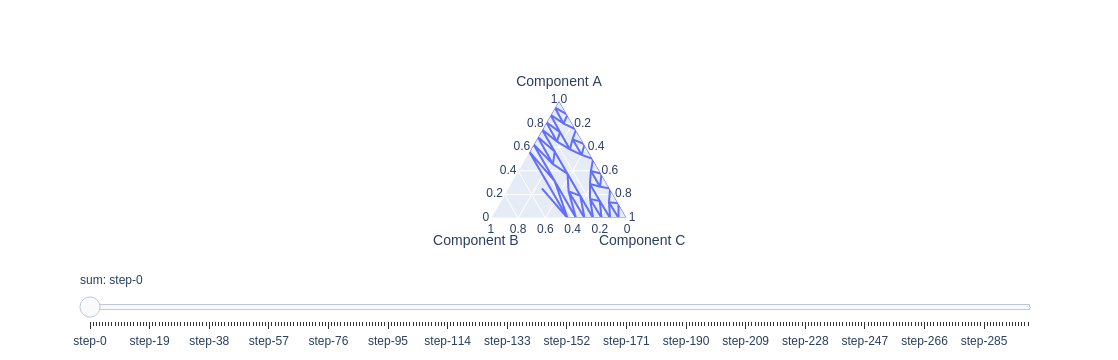

In [45]:
# Demonostration of full rotation mapping

fig = go.Figure()
pulse_list = sierpinksi_path(rgb_pulse(1,0,0),3)

path_progress = np.linspace(0,1,300)
for step in path_progress:

    df = pd.DataFrame()
    
    theta=3*pi/2 * step
    radius =1
    
    mat = scale_matrix(radius)@rotation_matrix_full(theta)
    
    for (idx,pulse) in enumerate(pulse_list):
        pulse=hue_step(pulse,-0.5)
        pulse.transform(mat.T)
        df[idx] = pulse.vals
    df = df.T
    df.columns = ['r','g','b']
    fig.add_trace( go.Scatterternary(a=df['b'],b=df['r'],c=df['g'],visible=False)) 
                  
fig.data[0].visible = True
                  
                  
# Create and add slider
steps = []
for (i,step_val) in enumerate(path_progress):
    step = dict(
        method="update",
        args=[{"visible": [False] * len(fig.data)},
              {"title": f"theta  "}],  # layout attribute
    )
    step["args"][0]["visible"][i] = True  # Toggle i'th trace to "visible"
    steps.append(step)

sliders = [dict(
    active=0,
    currentvalue={"prefix": "sum: "},
    pad={"t": 50},
    steps=steps
)]

fig.update_layout(
    sliders=sliders
)

fig.show()
                  



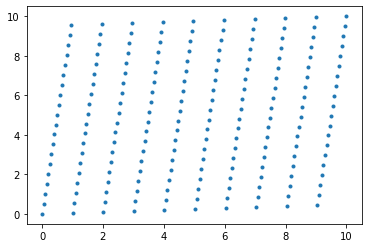

In [27]:
import numpy as np
from matplotlib import pyplot as plt
def map_wrap(val,old_min,old_max,new_min,new_max):
    
    #print(f"{val=}")
    if (val > old_max):
        diff = -old_max
        return map_wrap( val+diff, old_min,old_max,new_min,new_max     )
    if (val < old_min):
        diff = old_min
        return map_wrap(val+diff,old_min,old_max,new_min,new_max)
    return (val - old_min) * (new_max - new_min) / (old_max - old_min) + old_min;

def map_bounce(val,old_min,old_max,new_min,new_max):
    
    #print(f"{val=}")
    if (val > old_max):
        diff = val-old_max
        return map_bounce( val-2*diff, old_min,old_max,new_min,new_max     )
    if (val < old_min):
        diff = old_min-val
        return map_bounce(val+2*diff,old_min,old_max,new_min,new_max)
    return (val - old_min) * (new_max - new_min) / (old_max - old_min) + old_min;

vals = np.linspace(0,10,200)
wraps = [ map_wrap(val,0,1,0,10) for val in vals]
plt.plot(vals,wraps,".")
plt.show()

In [42]:
def hue_step(init_rgb, step_size):
    """
    Shift an rgb_pulse to or away from the R corner
        @param: step_size (float), within range [-1,1]
        @param: init_rgb  (rgb_pulse), initial rgb_pulse before step
        @returns: hue_step (rgb_pulse), transformed rgb_pulse
    """
    
    ## constrain step size to be within [-1,1] range
    t=np.clip(step_size,-1,1)
    r,g,b = init_rgb.vals
    
    ## edge case if pulse is pure R:
    if 0 == g+b:
        init_rgb=init_rgb+rgb_step(-2,1,1)
        r,g,b = init_rgb.vals
    if t>= 0:
        delta_g = int(-g*t)
        delta_b = int(-b*t)
        delta_r = -delta_g-delta_b
    elif t<0:
        delta_g = int(-g*r*t / (g+b))
        delta_b = int(-b*r*t / (g+b))
        delta_r = -delta_g-delta_b
    
    delta = rgb_step( delta_r,delta_g,delta_b )
        
    return init_rgb + delta

In [32]:
pulse = rgb_pulse( 1,1,1)
print(pulse)
hue_step(pulse,-1)

rgb_pulse(86,85,85)


rgb_pulse(0,128,128)

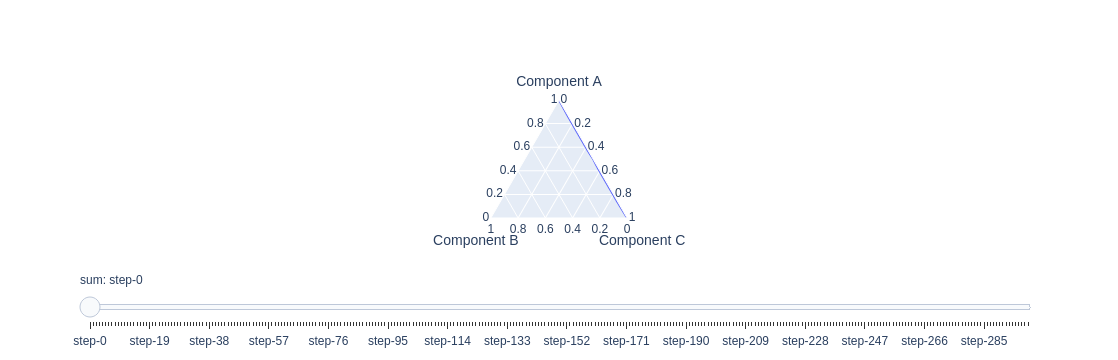

In [43]:
# Demonostration of the hue step mapping

fig = go.Figure()

path_progress = np.linspace(-1,1,300)
for step in path_progress:

    df = pd.DataFrame()
    pulse_list = sierpinksi_path(rgb_pulse(1,0,0),3)
    
    
    for (idx,pulse) in enumerate(pulse_list):
        pulse=hue_step(pulse,step)
        df[idx] = pulse.vals
    df = df.T
    df.columns = ['r','g','b']
    fig.add_trace( go.Scatterternary(a=df['b'],b=df['r'],c=df['g'],visible=False)) 
                  
fig.data[0].visible = True
                  
                  
# Create and add slider
steps = []
for (i,step_val) in enumerate(path_progress):
    step = dict(
        method="update",
        args=[{"visible": [False] * len(fig.data)},
              {"title": f"step_param  "}],  # layout attribute
    )
    step["args"][0]["visible"][i] = True  # Toggle i'th trace to "visible"
    steps.append(step)

sliders = [dict(
    active=0,
    currentvalue={"prefix": "sum: "},
    pad={"t": 50},
    steps=steps
)]

fig.update_layout(
    sliders=sliders
)

fig.show()